In [1]:
import os
import pandas
import pickle
import keras
# import tensorflow.keras as keras
import numpy as np
from sklearn.model_selection import train_test_split

#Config
PLOT_ON = False
LOAD_PARTIAL = True
REF_DIR = "in"
MEDIA_DIR = "out"
MODEL_NAME = "model3.pkl"
PIPELINE_NAME = "pipeline3.pkl"

#Load up the test data from the Pickle file
def load_data(b_load_partial_data):
    if not b_load_partial_data:
        DATA_NAME = "project3trainset.pkl"
        LABEL_NAME = "project3trainlabel.pkl"
        data_path = os.path.join(REF_DIR, DATA_NAME)
        with open(data_path, "rb") as data_in:
            data_X = pandas.read_pickle(data_in)
        label_path = os.path.join(REF_DIR, LABEL_NAME)
        with open(label_path, "rb") as data_in:
            data_Y = pandas.read_pickle(data_in)
    else:
        LABEL_NAME = "project3trainlabel.pkl"
        label_path = os.path.join(REF_DIR, LABEL_NAME)
        with open(label_path, "rb") as data_in:
            data_Y = pandas.read_pickle(data_in)
        for i in range(4):
            data_name = "project3trainset_0"+str(i+1)+".pkl"
            data_path = os.path.join(REF_DIR, data_name)
            if i == 0:
                with open(data_path, "rb") as data_in:
                    data_X = pandas.read_pickle(data_in)
            else:
                with open(data_path, "rb") as data_in:
                    data_X = np.concatenate((data_X, pandas.read_pickle(data_in)))
    return [data_X, data_Y]

[data_features, data_labels] = load_data(LOAD_PARTIAL)
print(data_features.shape)

(55000, 28, 28)


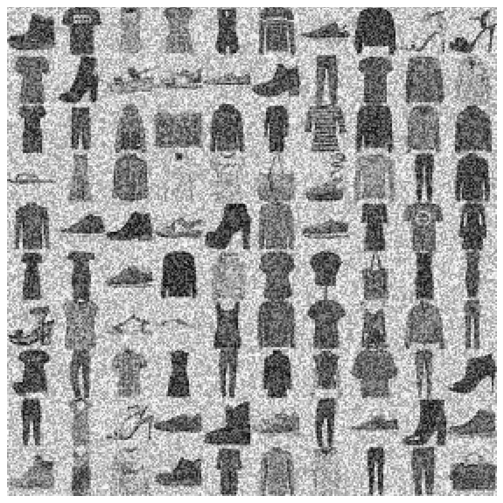

In [66]:
#Plot a sample of the data set
import matplotlib.pyplot as plot_digits
import matplotlib
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instances[i:i+1].reshape(size,size) for i in range(instances.shape[0])]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
#%%
plt.figure(figsize=(9,9))
example_images = data_features[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [2]:
#Data and mappable labels
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#Reshape data to fit
new_shape = list(data_features.shape)
new_shape.insert(3, 1)
new_shape = tuple(new_shape)
reshape_data = data_features.reshape(new_shape)

data_train, data_val, label_train, label_val = train_test_split(reshape_data, data_labels, test_size=0.2)
data_train_2, data_test, label_train_2, label_test = train_test_split(reshape_data, data_labels, test_size=0.1)

In [10]:
#Create Over-Valued Model
model = keras.models.Sequential([
    keras.layers.Conv2D(16, 7, activation="relu", padding="same",
        input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

#Grabbing info about our layers
print("Parameter Num: "+str(model.count_params()))
print(model.summary())

Parameter Num: 1356138
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 28, 28, 16)        800       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 14, 14, 128)       18560     
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_172 (Conv2D)          (N

In [71]:
#Test if book model likes our data
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(data_train, label_train, epochs=1, validation_data=(data_val, label_val))
score = model.evaluate(data_test, label_test)

172/172 [==============================] - 7s 43ms/step - loss: 0.4129 - accuracy: 0.8509


In [81]:
#Experimenting with a ResNet
#ResNet-34 with Keras

#Define RU Unit
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

#Rest of model
model_res = keras.models.Sequential()
model_res.add(keras.layers.Conv2D(16, 7, strides=2, input_shape=(28, 28, 1),
    padding="same", use_bias=False))
model_res.add(keras.layers.BatchNormalization())
model_res.add(keras.layers.Activation("relu"))
model_res.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# model_res.add(keras.layers.Conv2D(16, 3, strides=2, input_shape=(28, 28, 1),
#     padding="same", use_bias=False))
# model_res.add(keras.layers.BatchNormalization())
# model_res.add(keras.layers.Activation("relu"))
# model_res.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# prev_filters = 64
for i in range(10):
    model_res.add(ResidualUnit(16, strides=1))
# for filters in [64] * 1 + [128] * 1 + [256] * 0 + [512] * 0:
#     strides = 1 if filters == prev_filters else 2
#     # strides=5
#     model_res.add(ResidualUnit(filters, strides=strides))
#     prev_filters = filters
model_res.add(keras.layers.GlobalAvgPool2D())
model_res.add(keras.layers.Flatten())
model_res.add(keras.layers.Dense(10, activation="softmax"))
print("Parameter Num: "+str(model_res.count_params()))
print(model_res.summary())

Parameter Num: 48378
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_535 (Conv2D)          (None, 14, 14, 16)        784       
_________________________________________________________________
batch_normalization_530 (Bat (None, 14, 14, 16)        64        
_________________________________________________________________
activation_50 (Activation)   (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
residual_unit_202 (ResidualU (None, 7, 7, 16)          4736      
_________________________________________________________________
residual_unit_203 (ResidualU (None, 7, 7, 16)          4736      
_________________________________________________________________
residual_unit_204 (ResidualU (No

In [87]:
#Fit ResNet
model_res.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model_res.fit(data_train, label_train, epochs=25, validation_data=(data_val, label_val))
score = model_res.evaluate(data_test, label_test)

Epoch 1/25
1375/1375 [==============================] - 64s 41ms/step - loss: 0.2660 - accuracy: 0.9014 - val_loss: 0.3969 - val_accuracy: 0.8579
Epoch 2/25
1375/1375 [==============================] - 55s 40ms/step - loss: 0.2528 - accuracy: 0.9039 - val_loss: 0.4356 - val_accuracy: 0.8486
Epoch 3/25
1375/1375 [==============================] - 54s 40ms/step - loss: 0.2447 - accuracy: 0.9086 - val_loss: 0.4626 - val_accuracy: 0.8422
Epoch 4/25
1375/1375 [==============================] - 55s 40ms/step - loss: 0.2307 - accuracy: 0.9146 - val_loss: 0.4185 - val_accuracy: 0.8569
Epoch 5/25
1375/1375 [==============================] - 56s 40ms/step - loss: 0.2214 - accuracy: 0.9178 - val_loss: 0.4413 - val_accuracy: 0.8524
Epoch 6/25
1375/1375 [==============================] - 56s 40ms/step - loss: 0.2182 - accuracy: 0.9181 - val_loss: 0.4973 - val_accuracy: 0.8371
Epoch 7/25
1375/1375 [==============================] - 54s 39ms/step - loss: 0.2121 - accuracy: 0.9188 - val_loss: 0.4286 -

In [88]:
#Cross validation checking
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

print("Reduced Res CNN:\n====================")
print("Test Accuracy Score: "+str(model_res.evaluate(data_train, label_train)))
print("Validation Accuracy Score: "+str(model_res.evaluate(data_val, label_val)))

Reduced Res CNN:
1375/1375 [==============================] - 10s 7ms/step - loss: 0.1594 - accuracy: 0.9386
Test Accuracy Score: [0.15943162143230438, 0.9385681748390198]
344/344 [==============================] - 2s 7ms/step - loss: 0.6057 - accuracy: 0.8459
Validation Accuracy Score: [0.6057398915290833, 0.8459091186523438]
